# Single Latent Evolution: Watch a Shape Form

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jtooates/blind_lm/blob/main/experiments/single_latent_evolution.ipynb)

This notebook lets you watch a **single latent image** evolve step-by-step under different loss functions.

**Purpose**: Understand how each loss affects the visual appearance during optimization.

**Workflow**:
1. Configure loss weights
2. Start with random noise
3. Watch it transform into a shape frame-by-frame

## Setup

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

print(f"PyTorch version: {torch.__version__}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

PyTorch version: 2.2.2
Using device: cpu


## Loss Functions

In [ ]:
def compute_losses(latent, patch_size=3, num_samples=100, temperature=0.1):
    """
    Compute all loss components for a single latent [H, W].
    Returns dict of individual losses.
    
    Args:
        latent: [H, W] tensor
        patch_size: Size of patches for InfoNCE (default 3x3)
        num_samples: Number of anchor patches to sample for InfoNCE
        temperature: Temperature for InfoNCE similarity
    """
    # Add batch dimension for compatibility
    latent_batch = latent.unsqueeze(0)  # [1, H, W]
    losses = {}
    
    # 1. Sparsity: encourages most pixels → 0 (background)
    losses['sparsity'] = torch.mean(torch.abs(latent))
    
    # 2. Binary: pushes pixels toward -1 or +1 (sharp black/white)
    distance_from_binary = torch.min(
        (latent - 1.0)**2,
        (latent + 1.0)**2
    )
    losses['binary'] = torch.mean(distance_from_binary)
    
    # 3. Total Variation: smoothness within regions (penalizes edges)
    dx = torch.abs(latent[1:, :] - latent[:-1, :])
    dy = torch.abs(latent[:, 1:] - latent[:, :-1])
    losses['tv'] = torch.mean(dx) + torch.mean(dy)
    
    # 4. Object Size: enforces target ratio of bright pixels
    threshold = 0.5
    binary_mask = (latent > threshold).float()
    bright_ratio = torch.mean(binary_mask)
    target_ratio = 0.25
    losses['object_size'] = (bright_ratio - target_ratio)**2
    
    # 5. Magnitude: prevents collapse to near-zero values
    magnitude = torch.mean(torch.abs(latent))
    min_magnitude = 0.3
    losses['magnitude'] = torch.relu(min_magnitude - magnitude)
    
    # 6a. Autocorrelation 4-connected (cardinal directions only)
    dx_corr = latent[1:, :] * latent[:-1, :]
    dy_corr = latent[:, 1:] * latent[:, :-1]
    autocorr_4 = torch.mean(dx_corr) + torch.mean(dy_corr)
    losses['coherence_autocorr_4'] = -autocorr_4
    
    # 6b. Autocorrelation 8-connected (includes diagonals)
    d1_corr = latent[1:, 1:] * latent[:-1, :-1]
    d2_corr = latent[1:, :-1] * latent[:-1, 1:]
    autocorr_8 = autocorr_4 + torch.mean(d1_corr) + torch.mean(d2_corr)
    losses['coherence_autocorr_8'] = -autocorr_8
    
    # 6c. InfoNCE patch coherence
    # Positive pairs: spatially nearby patches
    # Negative pairs: spatially distant patches
    H, W = latent.shape
    pad = patch_size // 2
    
    # Extract all possible patches via unfold
    latent_padded = F.pad(latent.unsqueeze(0).unsqueeze(0), 
                          (pad, pad, pad, pad), mode='replicate')
    patches = F.unfold(latent_padded, kernel_size=patch_size, stride=1)  # [1, patch_size^2, H*W]
    patches = patches.squeeze(0).t()  # [H*W, patch_size^2]
    
    # Sample anchor positions
    num_positions = H * W
    if num_samples > num_positions:
        num_samples = num_positions
    
    anchor_indices = torch.randperm(num_positions)[:num_samples]
    anchor_patches = patches[anchor_indices]  # [num_samples, patch_size^2]
    
    # For each anchor, define positive and negative samples based on spatial distance
    # Positive: within distance threshold (e.g., distance <= 2)
    # Negative: beyond distance threshold (e.g., distance > 4)
    anchor_coords = torch.stack([
        anchor_indices // W,  # y coordinates
        anchor_indices % W    # x coordinates
    ], dim=1).float()  # [num_samples, 2]
    
    # All patch coordinates
    y_coords = torch.arange(H).unsqueeze(1).expand(H, W).reshape(-1)
    x_coords = torch.arange(W).unsqueeze(0).expand(H, W).reshape(-1)
    all_coords = torch.stack([y_coords, x_coords], dim=1).float()  # [H*W, 2]
    
    # Compute pairwise distances for each anchor
    infonce_loss = 0.0
    for i in range(num_samples):
        anchor_patch = anchor_patches[i:i+1]  # [1, patch_size^2]
        anchor_coord = anchor_coords[i:i+1]   # [1, 2]
        
        # Compute spatial distances
        distances = torch.norm(all_coords - anchor_coord, dim=1)  # [H*W]
        
        # Define positive and negative masks
        pos_mask = (distances > 0) & (distances <= 2.0)  # Nearby (but not self)
        neg_mask = distances > 4.0  # Distant
        
        if pos_mask.sum() > 0 and neg_mask.sum() > 0:
            # Compute similarities (cosine similarity)
            anchor_norm = F.normalize(anchor_patch, dim=1)
            patches_norm = F.normalize(patches, dim=1)
            similarities = torch.matmul(anchor_norm, patches_norm.t()).squeeze(0)  # [H*W]
            
            # InfoNCE: log( exp(sim_pos) / (exp(sim_pos) + sum(exp(sim_neg))) )
            # We want to maximize this, so minimize negative
            pos_sims = similarities[pos_mask] / temperature
            neg_sims = similarities[neg_mask] / temperature
            
            # Log-sum-exp trick for numerical stability
            pos_exp = torch.exp(pos_sims)
            neg_exp = torch.exp(neg_sims)
            
            # Loss: -log(mean(pos) / (mean(pos) + mean(neg)))
            infonce_loss += -torch.log(pos_exp.mean() / (pos_exp.mean() + neg_exp.mean() + 1e-8))
    
    losses['coherence_infonce'] = infonce_loss / max(num_samples, 1)
    
    # 7. Perimeter-to-Area: compact blobs vs scattered pixels
    temperature_edge = 0.1
    binary_soft = torch.sigmoid((latent - threshold) / temperature_edge)
    dx_edge = torch.abs(binary_soft[1:, :] - binary_soft[:-1, :])
    dy_edge = torch.abs(binary_soft[:, 1:] - binary_soft[:, :-1])
    edge_length = torch.sum(dx_edge) + torch.sum(dy_edge)
    area = torch.sum(binary_soft) + 1e-6
    losses['coherence_perimeter'] = edge_length / area
    
    # 8. Morphological: penalizes scattered pixels
    latent_4d = latent_batch.unsqueeze(1)  # [1, 1, H, W]
    pooled = F.max_pool2d(latent_4d, kernel_size=3, stride=1, padding=1)
    unpooled = -F.max_pool2d(-pooled, kernel_size=3, stride=1, padding=1)
    unpooled = unpooled.squeeze()
    losses['coherence_morphological'] = torch.mean((latent - unpooled) ** 2)
    
    return losses

print("✓ Loss functions defined")
print("\nCoherence loss variants:")
print("  coherence_autocorr_4:     4-connected autocorrelation")
print("  coherence_autocorr_8:     8-connected autocorrelation")
print("  coherence_infonce:        InfoNCE patch similarity (nearby=positive, distant=negative)")
print("  coherence_perimeter:      Perimeter-to-area ratio")
print("  coherence_morphological:  Morphological smoothness")

## 1. Configure Loss Weights

**Adjust these to control what the image looks like!**

Set any weight to `0` to disable that loss.

In [ ]:
# ============================================================================
# LOSS WEIGHTS - EXPERIMENT WITH THESE!
# ============================================================================

weights = {
    # Sparsity: encourages most pixels → 0 (background)
    # Higher = more black background, fewer active pixels
    'sparsity': 0.1,
    
    # Binary: pushes pixels toward -1 or +1 (sharp black/white)
    # Higher = sharper boundaries, less gray
    'binary': 1.0,
    
    # Total Variation: smoothness within regions (penalizes edges)
    # Higher = smoother blobs, fewer sharp edges
    'tv': 0.05,
    
    # Object Size: enforces target ratio of bright pixels (~25%)
    # Higher = stronger enforcement of target coverage
    'object_size': 2.0,
    
    # Magnitude: prevents collapse to near-zero values
    # Higher = forces stronger signals
    'magnitude': 5.0,
    
    # Coherence - Autocorrelation (choose ONE or compare):
    'coherence_autocorr_4': 2.0,      # 4-connected (horizontal/vertical)
    'coherence_autocorr_8': 0.0,      # 8-connected (includes diagonals)
    
    # Coherence - InfoNCE patch similarity
    # Encourages nearby patches to be similar, distant patches to differ
    # Good for: local smoothness with global diversity
    'coherence_infonce': 0.0,         # InfoNCE patch-based coherence
    
    # Other coherence types:
    'coherence_perimeter': 0.0,       # Perimeter-to-area ratio
    'coherence_morphological': 0.0,   # Morphological smoothness
}

# ============================================================================
# INFONCE PARAMETERS (only used if coherence_infonce > 0)
# ============================================================================

infonce_patch_size = 3       # Patch size for InfoNCE (e.g., 3 = 3x3 patches)
infonce_num_samples = 100    # Number of anchor patches to sample per step
infonce_temperature = 0.1    # Temperature for similarity computation

# ============================================================================
# OPTIMIZATION SETTINGS
# ============================================================================

num_steps = 500              # Total optimization steps
snapshot_interval = 25       # Save visualization every N steps
learning_rate = 0.02         # Adam learning rate
image_size = 32              # Latent is 32x32
random_seed = 42             # For reproducibility (None = random)

# ============================================================================

print("Configuration:")
print(f"  Total steps: {num_steps}")
print(f"  Snapshots every {snapshot_interval} steps")
print(f"  Expected snapshots: {num_steps // snapshot_interval + 1}")
print(f"  Learning rate: {learning_rate}")
if weights.get('coherence_infonce', 0) > 0:
    print(f"\nInfoNCE parameters:")
    print(f"  Patch size: {infonce_patch_size}x{infonce_patch_size}")
    print(f"  Num samples: {infonce_num_samples}")
    print(f"  Temperature: {infonce_temperature}")
print(f"\nActive losses:")
for name, weight in weights.items():
    if weight > 0:
        print(f"  {name:30s}: {weight:.2f}")

## 2. Initialize Single Latent

Start with Gaussian noise + a blob seed

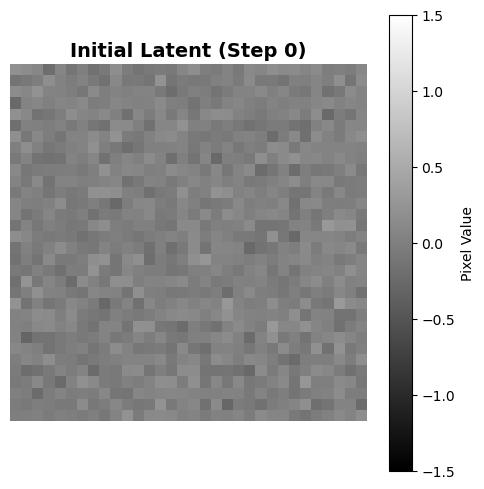

✓ Initialized latent: torch.Size([32, 32])
  Min value: -0.310
  Max value: 0.303
  Mean value: 0.001


In [78]:
# Set random seed if specified
if random_seed is not None:
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

# Initialize single latent [H, W]
latent = torch.randn(image_size, image_size) * 0.1

# Add a random blob to break symmetry
for _ in range(0):
    y = np.random.randint(5, image_size - 5)
    x = np.random.randint(5, image_size - 5)
    size = np.random.randint(3, 7)
    
    yy, xx = torch.meshgrid(
        torch.arange(image_size) - y,
        torch.arange(image_size) - x,
        indexing='ij'
    )
    blob = torch.exp(-(yy**2 + xx**2) / (2 * size**2))
    latent += blob * np.random.uniform(0.5, 1.5)

latent = latent.to(device)
latent.requires_grad_(True)

# Visualize initial state
plt.figure(figsize=(5, 5))
plt.imshow(latent.detach().cpu().numpy(), cmap='gray', vmin=-1.5, vmax=1.5)
plt.title('Initial Latent (Step 0)', fontsize=14, fontweight='bold')
plt.colorbar(label='Pixel Value')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"✓ Initialized latent: {latent.shape}")
print(f"  Min value: {latent.min().item():.3f}")
print(f"  Max value: {latent.max().item():.3f}")
print(f"  Mean value: {latent.mean().item():.3f}")

## 3. Run Optimization with Snapshots

Watch the latent evolve step by step!

In [ ]:
# Reset latent (re-run cell above if you want new random init)
optimizer = torch.optim.Adam([latent], lr=learning_rate)

# Storage for snapshots
snapshots = []
snapshot_steps = []
loss_history = []

# Save initial state
snapshots.append(latent.detach().cpu().numpy().copy())
snapshot_steps.append(0)

print("Starting optimization...\n")

for step in range(num_steps):
    optimizer.zero_grad()
    
    # Compute all losses with InfoNCE parameters
    losses = compute_losses(
        latent,
        patch_size=infonce_patch_size,
        num_samples=infonce_num_samples,
        temperature=infonce_temperature
    )
    
    # Build weighted total loss
    total_loss = sum(losses[name] * weights[name] for name in losses if name in weights)
    
    # Optimize
    total_loss.backward()
    optimizer.step()
    
    # Clamp to valid range
    with torch.no_grad():
        latent.clamp_(-1.5, 1.5)
    
    loss_history.append(total_loss.item())
    
    # Save snapshot
    if (step + 1) % snapshot_interval == 0:
        snapshots.append(latent.detach().cpu().numpy().copy())
        snapshot_steps.append(step + 1)
        print(f"Step {step + 1:3d}/{num_steps}: Loss = {total_loss.item():.4f}")

# Save final state if not already saved
if num_steps % snapshot_interval != 0:
    snapshots.append(latent.detach().cpu().numpy().copy())
    snapshot_steps.append(num_steps)

print(f"\n✓ Optimization complete!")
print(f"  Captured {len(snapshots)} snapshots")
print(f"  Final loss: {loss_history[-1]:.4f}")
print(f"  Initial loss: {loss_history[0]:.4f}")

## 4. Visualize Evolution

See all snapshots in a grid

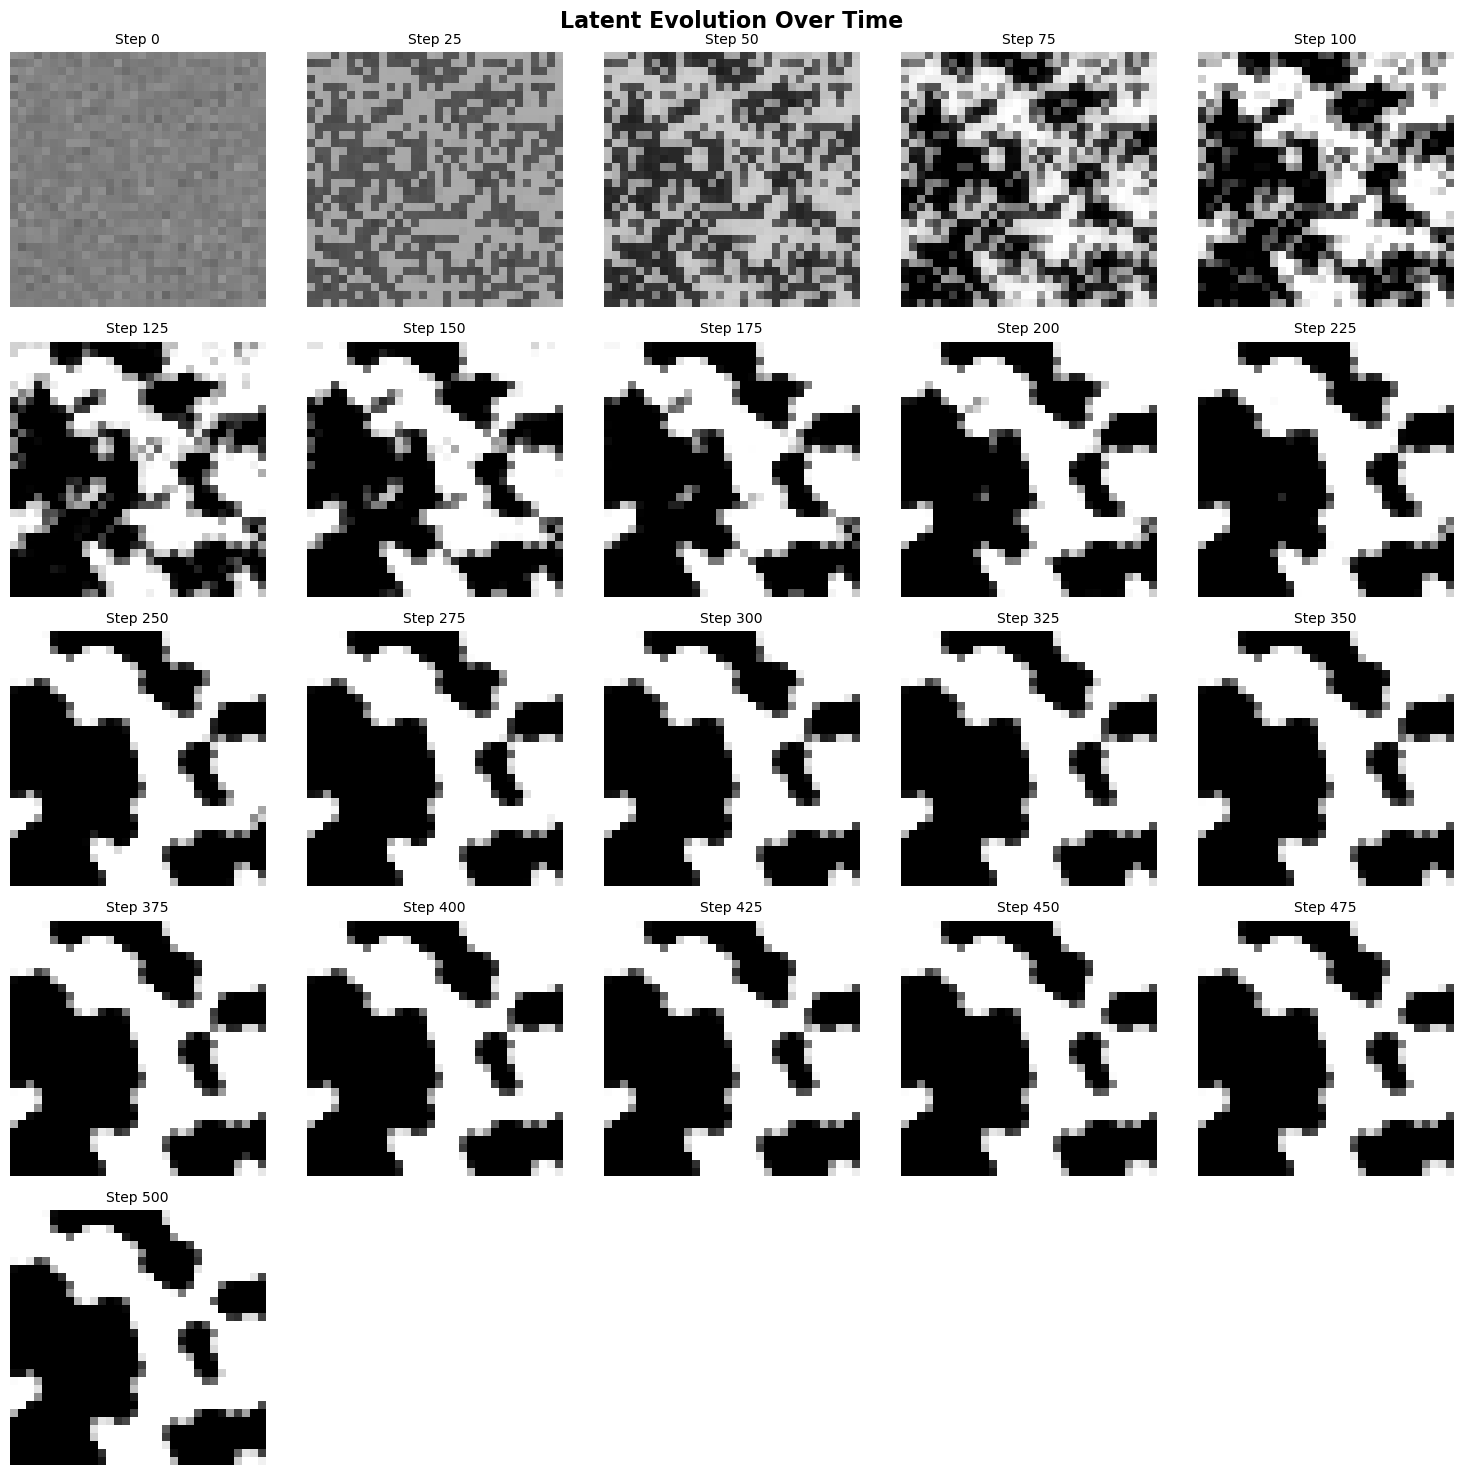


Evolution summary:
  Initial → Final: 0 → 500 steps
  You can see the transformation from random noise to structured shape!


In [80]:
# Calculate grid size
num_snapshots = len(snapshots)
cols = min(5, num_snapshots)
rows = (num_snapshots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
if rows == 1:
    axes = axes.reshape(1, -1)
if cols == 1:
    axes = axes.reshape(-1, 1)

for idx, (snapshot, step) in enumerate(zip(snapshots, snapshot_steps)):
    row = idx // cols
    col = idx % cols
    
    ax = axes[row, col]
    ax.imshow(snapshot, cmap='gray', vmin=-1.5, vmax=1.5)
    ax.set_title(f'Step {step}', fontsize=10)
    ax.axis('off')

# Hide unused subplots
for idx in range(num_snapshots, rows * cols):
    row = idx // cols
    col = idx % cols
    axes[row, col].axis('off')

plt.suptitle('Latent Evolution Over Time', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nEvolution summary:")
print(f"  Initial → Final: {snapshot_steps[0]} → {snapshot_steps[-1]} steps")
print(f"  You can see the transformation from random noise to structured shape!")

## 5. Plot Loss Curve

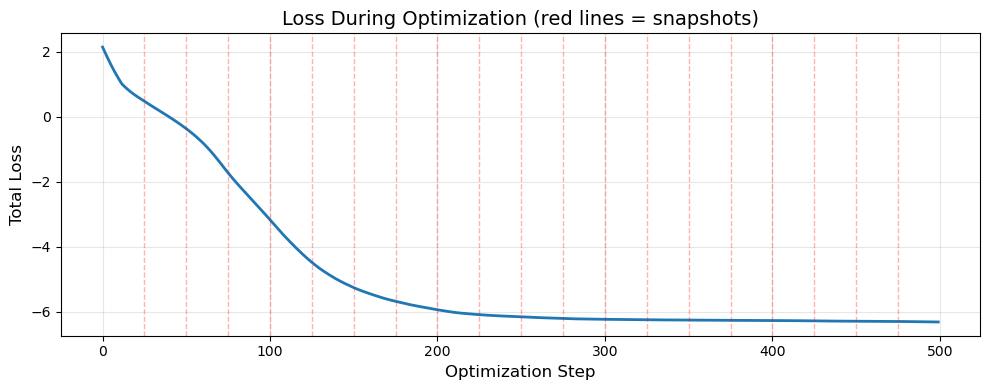

Loss reduction: 395.4%


In [81]:
plt.figure(figsize=(10, 4))
plt.plot(loss_history, linewidth=2)

# Mark snapshot points
for step in snapshot_steps[1:]:  # Skip initial
    if step < len(loss_history):
        plt.axvline(x=step, color='red', alpha=0.3, linestyle='--', linewidth=1)

plt.xlabel('Optimization Step', fontsize=12)
plt.ylabel('Total Loss', fontsize=12)
plt.title('Loss During Optimization (red lines = snapshots)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Loss reduction: {(loss_history[0] - loss_history[-1]) / abs(loss_history[0]) * 100:.1f}%")

## 6. Side-by-Side Comparison

See initial vs final clearly

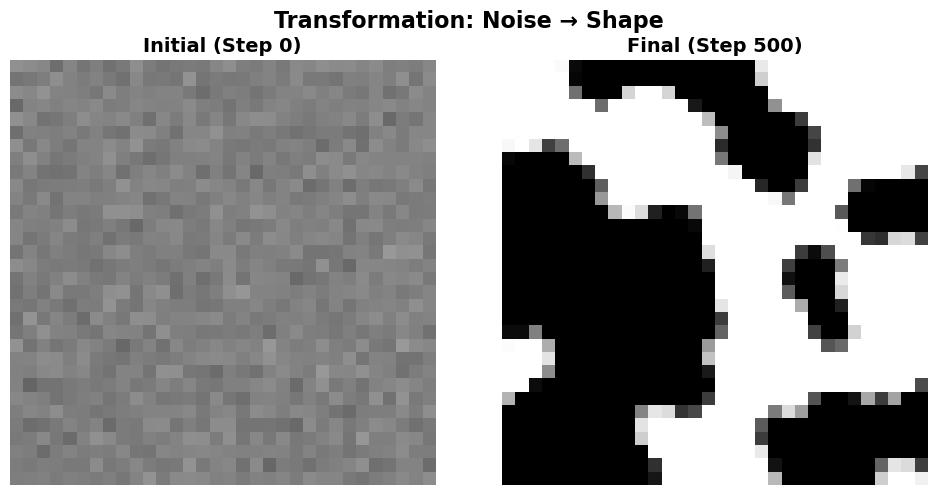

Initial latent:
  Min: -0.310
  Max: 0.303
  Mean: 0.001
  Std: 0.100

Final latent:
  Min: -1.500
  Max: 1.500
  Mean: -0.031
  Std: 1.449


In [82]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Initial
axes[0].imshow(snapshots[0], cmap='gray', vmin=-1.5, vmax=1.5)
axes[0].set_title(f'Initial (Step {snapshot_steps[0]})', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Final
axes[1].imshow(snapshots[-1], cmap='gray', vmin=-1.5, vmax=1.5)
axes[1].set_title(f'Final (Step {snapshot_steps[-1]})', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.suptitle('Transformation: Noise → Shape', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics
print("Initial latent:")
print(f"  Min: {snapshots[0].min():.3f}")
print(f"  Max: {snapshots[0].max():.3f}")
print(f"  Mean: {snapshots[0].mean():.3f}")
print(f"  Std: {snapshots[0].std():.3f}")

print("\nFinal latent:")
print(f"  Min: {snapshots[-1].min():.3f}")
print(f"  Max: {snapshots[-1].max():.3f}")
print(f"  Mean: {snapshots[-1].mean():.3f}")
print(f"  Std: {snapshots[-1].std():.3f}")

## 7. Analyze Individual Loss Components

See how each loss evolves

In [ ]:
# Recompute losses at each snapshot
loss_components_history = {name: [] for name in weights.keys()}

for snapshot in snapshots:
    snapshot_tensor = torch.tensor(snapshot, dtype=torch.float32)
    losses = compute_losses(
        snapshot_tensor,
        patch_size=infonce_patch_size,
        num_samples=infonce_num_samples,
        temperature=infonce_temperature
    )
    for name in weights.keys():
        loss_components_history[name].append(losses[name].item())

# Plot active losses
active_losses = {name: values for name, values in loss_components_history.items() 
                if weights[name] > 0}

if active_losses:
    fig, axes = plt.subplots(len(active_losses), 1, figsize=(10, 3 * len(active_losses)))
    if len(active_losses) == 1:
        axes = [axes]
    
    for ax, (name, values) in zip(axes, active_losses.items()):
        ax.plot(snapshot_steps, values, linewidth=2, marker='o')
        ax.set_xlabel('Step', fontsize=10)
        ax.set_ylabel('Loss Value', fontsize=10)
        ax.set_title(f'{name} (weight={weights[name]:.2f})', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No active losses to plot (all weights are 0)")

## Experiments to Try

Go back to the "Configure Loss Weights" cell and try:

### 1. Compare 4-connected vs 8-connected Autocorrelation

**4-connected only** (horizontal/vertical neighbors):
```python
'coherence_autocorr_4': 2.0,
'coherence_autocorr_8': 0.0,
```
**Expected**: May have slightly boxy or cross-shaped blobs

**8-connected only** (includes diagonals):
```python
'coherence_autocorr_4': 0.0,
'coherence_autocorr_8': 2.0,
```
**Expected**: Rounder, more circular blobs. Stronger coherence pressure.

**Both combined** (for maximum smoothness):
```python
'coherence_autocorr_4': 1.0,
'coherence_autocorr_8': 1.0,
```
**Expected**: Very smooth, very round blobs

### 2. Pure Coherence (No Other Losses)
```python
weights = {
    'sparsity': 0.0,
    'binary': 0.0,
    'tv': 0.0,
    'object_size': 0.0,
    'magnitude': 0.0,
    'coherence_autocorr_4': 2.0,  # or try _8
}
```
**Expected**: Smooth blobs, but may drift toward all positive or all negative

### 3. Coherence + Magnitude (Prevent Collapse)
```python
weights = {
    'magnitude': 5.0,
    'coherence_autocorr_4': 2.0,
}
```
**Expected**: Blobs with guaranteed signal strength

### 4. Full Stack (Recommended)
```python
weights = {
    'sparsity': 0.1,
    'binary': 1.0,
    'tv': 0.05,
    'object_size': 2.0,
    'magnitude': 5.0,
    'coherence_autocorr_4': 2.0,  # or try _8 for rounder shapes
}
```
**Expected**: Clean, compact blobs on sparse background

### 5. Test Diagonal Contribution

See how much diagonals help by trying the same weight for both:
```python
'coherence_autocorr_4': 1.0,
'coherence_autocorr_8': 0.0,  # then switch to 1.0
```
Compare the final shapes - are they noticeably rounder with 8-connected?

### 6. InfoNCE Patch Coherence

**InfoNCE only** (patch-based spatial coherence):
```python
'coherence_infonce': 2.0,
'magnitude': 5.0,  # Prevent collapse
```
**Expected**: Local smoothness with global diversity. Nearby patches become similar, distant patches differ.

**InfoNCE + Autocorrelation** (compare approaches):
```python
'coherence_autocorr_4': 1.0,
'coherence_infonce': 1.0,
'magnitude': 5.0,
```
**Expected**: Both encourage coherence but via different mechanisms. InfoNCE looks at patch neighborhoods (3×3 regions), autocorrelation at pixel pairs.

**Full stack with InfoNCE**:
```python
'sparsity': 0.1,
'binary': 1.0,
'object_size': 2.0,
'magnitude': 5.0,
'coherence_infonce': 2.0,
```
**Expected**: Clean blobs with smooth internal structure, learned through patch similarity